In [2]:
%pip install qiskit
%pip install qiskit-ibm-runtime

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\fouad\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: qiskit-ibm-runtime in c:\users\fouad\appdata\local\programs\python\python310\lib\site-packages (0.11.2)
  Using cached qiskit_terra-0.25.0-cp38-abi3-win_amd64.whl (5.1 MB)
  Attempting uninstall: qiskit-terra
    Found existing installation: qiskit-terra 0.24.1
    Uninstalling qiskit-terra-0.24.1:
      Successfully uninstalled qiskit-terra-0.24.1



ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
qiskit 0.43.2 requires qiskit-terra==0.24.1, but you have qiskit-terra 0.25.0 which is incompatible.
You should consider upgrading via the 'c:\Users\fouad\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


Paper Source

"Step-by-Step HHL Algorithm Walkthrough to Enhance the Understanding of Critical Quantum Computing Concepts"

https://arxiv.org/abs/2108.09004

<b>To cite</b>

Hector Morrell and Hiu Yung Wong, "Step-by-Step HHL Algorithm Walkthrough to Enhance the Understanding of Critical Quantum Computing Concepts", arXiv preprint arXiv:2108.09004


In [3]:
# Imports for Qiskit
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit import *
from qiskit import IBMQ, Aer
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.visualization import plot_histogram
import numpy as np
import qiskit
# Various imports 
import numpy as np

from copy import deepcopy
from matplotlib import pyplot as plt


from qiskit_ibm_runtime import QiskitRuntimeService, Sampler as SamplerIBM, Session, Options, Estimator
f = open("C:\\Users\\fouad\\Documents\\tokens.txt", "r")
next = f.readline()
# Put your own token here if you would like to run it
TOKEN_IBM = next[:len(next)-1]
service_ibm = QiskitRuntimeService(channel="ibm_quantum", token=TOKEN_IBM)
backend = service_ibm.backend("ibmq_qasm_simulator")


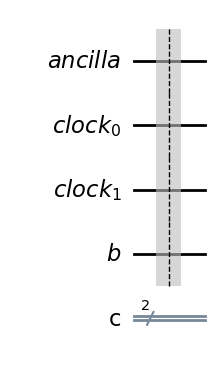

In [4]:
# Create the various registers needed
clock = QuantumRegister(2, name='clock')
input = QuantumRegister(1, name='b')
ancilla = QuantumRegister(1, name='ancilla')
measurement = ClassicalRegister(2, name='c')

# Create an empty circuit with the specified registers
circuit = QuantumCircuit(ancilla, clock, input, measurement)

circuit.barrier()
circuit.draw(output='mpl')

In [5]:
def qft_dagger(circ, q, n):      
    circ.h(clock[1]);
    for j in reversed(range(n)):
      for k in reversed(range(j+1,n)):
        circ.cp(-np.pi/float(2**(k-j)), q[k], q[j]); # changed cu1 to cp "controlled phase". new version of qiskit gates changed.
    circ.h(clock[0]);
    circ.swap(clock[0], clock[1]);

def qft(circ, q, n):
    circ.swap(clock[0], clock[1]);
    circ.h(clock[0]);
    for j in reversed(range(n)):
      for k in reversed(range(j+1,n)):
        circ.cp(np.pi/float(2**(k-j)), q[k], q[j]);
    circ.h(clock[1]);

In [6]:
def qpe(circ, clock, target):
    circuit.barrier()

    # e^{i*A*t}
    circuit.cu(np.pi/2, -np.pi/2, np.pi/2, 3*np.pi/4, clock[0], input, label='U');
    
    # e^{i*A*t*2}
    circuit.cu(np.pi, np.pi, 0, 0, clock[1], input, label='U2');

    circuit.barrier();
    
    # Perform an inverse QFT on the register holding the eigenvalues
    qft_dagger(circuit, clock, 2)
    
def inv_qpe(circ, clock, target):
    
    # Perform a QFT on the register holding the eigenvalues
    qft(circuit, clock, 2)

    circuit.barrier()

    # e^{i*A*t*2}
    circuit.cu(np.pi, np.pi, 0, 0, clock[1], input, label='U2');

    #circuit.barrier();

    # e^{i*A*t}
    circuit.cu(np.pi/2, np.pi/2, -np.pi/2, -3*np.pi/4, clock[0], input, label='U');

    circuit.barrier()

In [7]:
def hhl(circ, ancilla, clock, input, measurement):
    
    qpe(circ, clock, input)

    circuit.barrier()
    
    # This section is to test and implement C = 1
    circuit.cry(np.pi, clock[0], ancilla)
    circuit.cry(np.pi/3, clock[1], ancilla)

    circuit.barrier()
    
    circuit.measure(ancilla, measurement[0])
    circuit.barrier()
    inv_qpe(circ, clock, input)

In [8]:
# State preparation. 
intial_state = [0,1]
circuit.initialize(intial_state, 3)

circuit.barrier()

# Perform a Hadamard Transform
circuit.h(clock)

hhl(circuit, ancilla, clock, input, measurement)

# Perform a Hadamard Transform
circuit.h(clock)

circuit.barrier()


circuit.measure(input, measurement[1])

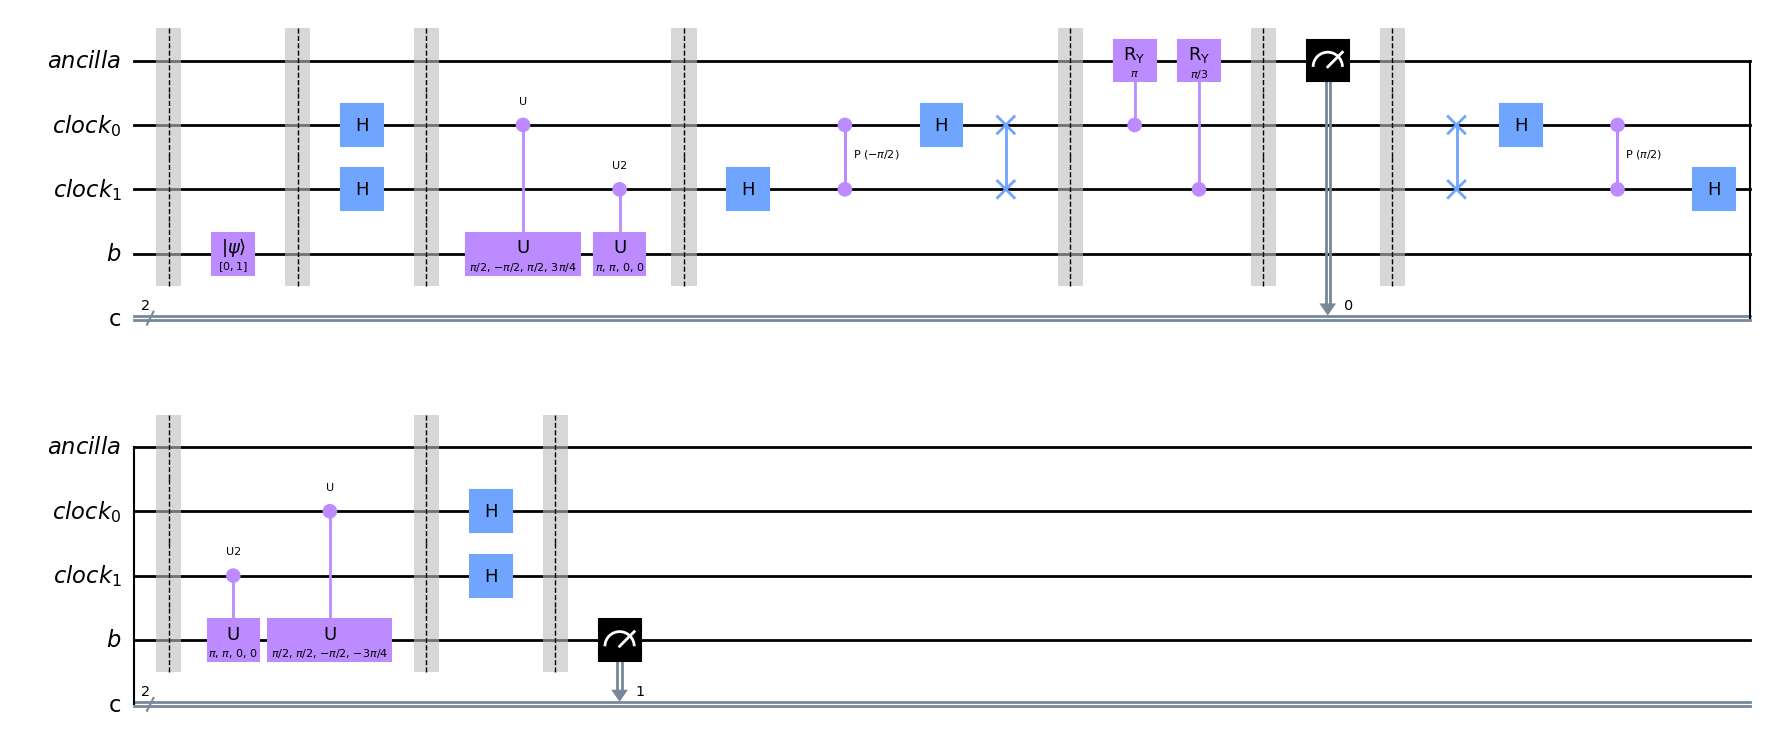

In [9]:
circuit.draw('mpl',scale=1)

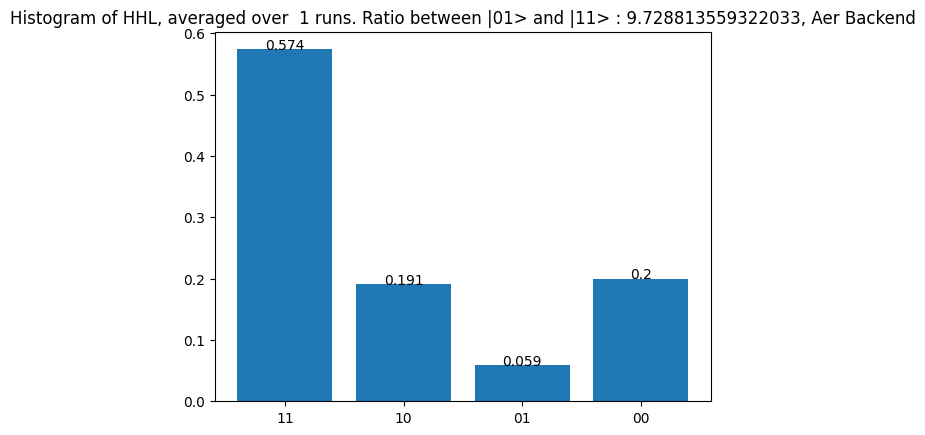

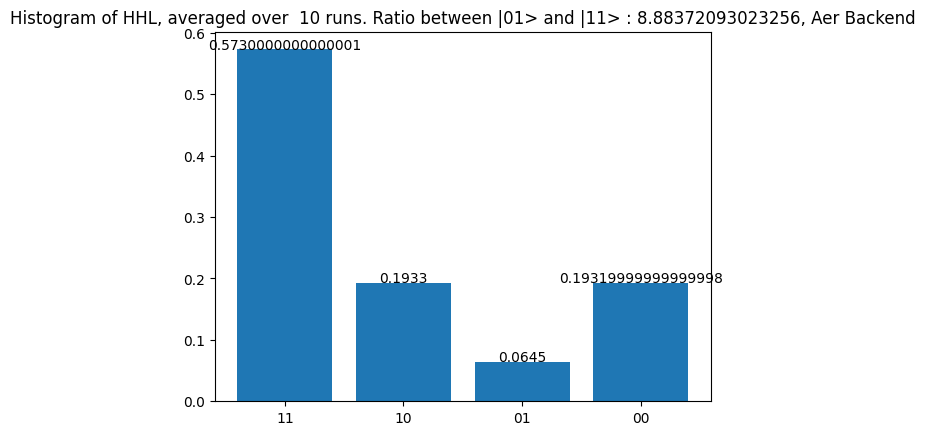

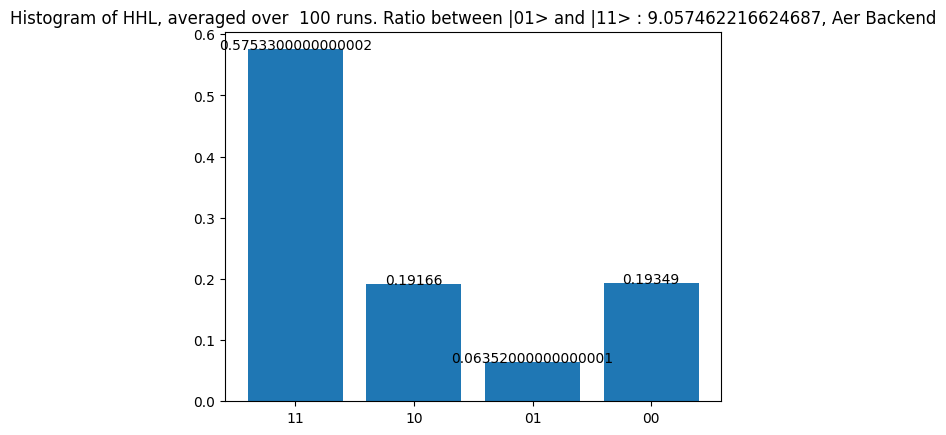

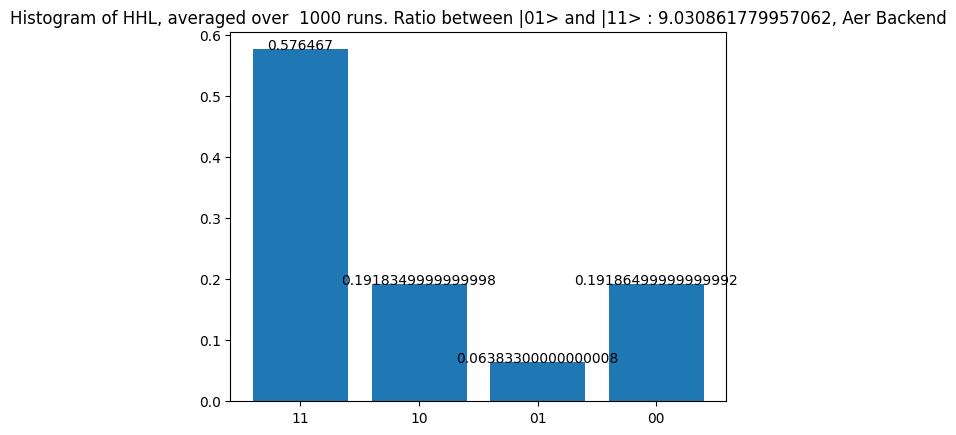

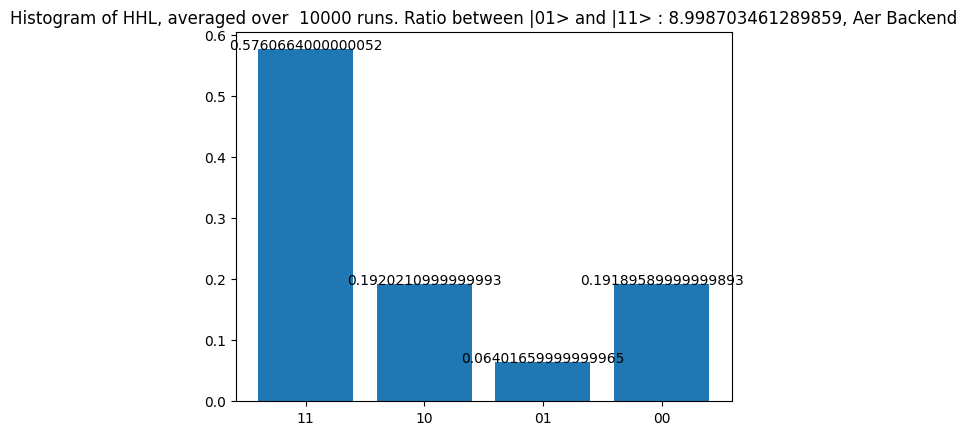

KeyboardInterrupt: 

In [135]:
# Execute the circuit using the simulator
backend_aer = Aer.get_backend('aer_simulator')
t_circ = transpile(circuit, backend=backend_aer)
ratios = []

for j in range(5):
    counts = {'11': 0, '10': 0, '01': 0, '00': 0}
    TIMES = 10 ** j
    for i in range(TIMES):
        job = backend_aer.run(t_circ)

        #Get the result of the execution
        result = job.result()

        # Get the counts, the frequency of each answer
        for k in result.get_counts(t_circ).keys():
            counts[k] += (result.get_counts(t_circ)[k]/1000)

    for k in counts.keys():
        counts[k] /= TIMES

    from matplotlib import pyplot as plt
    # Display the results
    plt.bar(counts.keys(), counts.values())
    for i in range(len(list(counts.keys()))):
        plt.text(i, list(counts.values())[i] , str(list(counts.values())[i]), ha = 'center')
    ratio = counts['11'] / counts['01']
    plt.title("Histogram of HHL, averaged over  " + str(TIMES) + " runs. Ratio between |01> and |11> : " + str(ratio) + ", Aer Backend" )
    ratios += [ratio]
    plt.show()



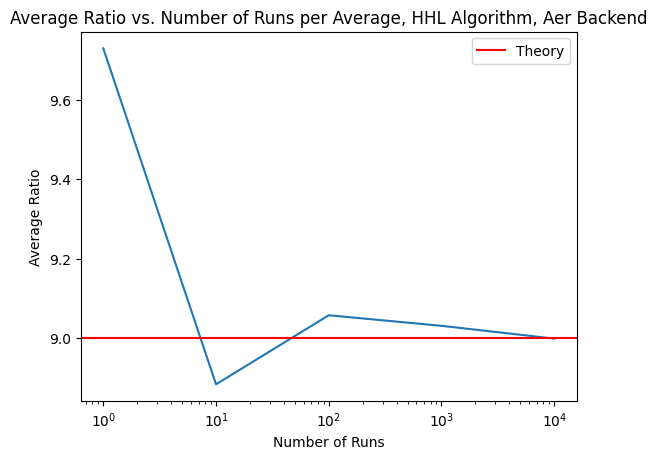

In [147]:
plt.plot([10**x for x in range(5)], ratios)
plt.axhline(y = 9, color = 'r', label="Theory")
plt.xlabel("Number of Runs")
plt.xscale("log")
plt.ylabel("Average Ratio")
plt.title("Average Ratio vs. Number of Runs per Average, HHL Algorithm, Aer Backend")
plt.legend()
plt.show()

In [ ]:
#IonQ Backend
%pip install qiskit-ionq
from qiskit_ionq import IonQProvider, ErrorMitigation
from qiskit import transpile
f = open("C:\\Users\\fouad\\Documents\\tokens.txt", "r")
next = f.readline()
next = f.readline()
# Put your own token here if you would like to run it
TOKEN_IONQ = next[:len(next)-1]
service_ionq = IonQProvider(TOKEN_IONQ)
backend_ionq = service_ionq.get_backend("ionq_simulator")

t_circ = transpile(circuit, backend=backend_ionq)
job = backend_ionq.run(circuit)

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\fouad\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


IonQGateError: IonQGateError("gate 'initialize' is not supported on the 'qis' IonQ backends. Please use the qiskit.transpile method, manually rewrite to remove the gate, or change the gateset selection as appropriate.")

In [ ]:
bcknd = Aer.get_backend('statevector_simulator')

job_sim = execute(circuit, bcknd)
result = job_sim.result()

o_state_result = result.get_statevector(circuit, decimals=3)
print(o_state_result)

Statevector([ 0.+0.j,  0.+0.j,  0.+0.j, -0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
              0.+0.j,  0.+0.j,  1.-0.j,  0.+0.j, -0.+0.j,  0.+0.j, -0.+0.j,
              0.+0.j, -0.-0.j],
            dims=(2, 2, 2, 2))


In [ ]:
service_ibm = QiskitRuntimeService(channel="ibm_quantum", token=TOKEN_IBM)
backend = service_ibm.backend("ibmq_qasm_simulator")

from qiskit.tools.monitor import job_monitor

# Execute the job
job_exp = execute(circuit, backend=backend, shots=8192)

# Monitor the job to know where we are in the queue
job_monitor(job_exp, interval = 2)

QiskitError: "Cannot unroll the circuit to the given basis, dict_keys(['u1', 'u2', 'u3', 'u', 'p', 'r', 'rx', 'ry', 'rz', 'cx', 'cy', 'cz', 'csx', 'cp', 'id', 'x', 'y', 'z', 'h', 's', 'sdg', 'sx', 't', 'tdg', 'swap', 'ccx', 'cswap', 'unitary', 'diagonal', 'initialize', 'cu1', 'cu2', 'cu3', 'rxx', 'ryy', 'rzz', 'rzx', 'mcx', 'mcy', 'mcz', 'mcsx', 'mcp', 'mcu1', 'mcu2', 'mcu3', 'mcrx', 'mcry', 'mcrz', 'mcr', 'mcswap', 'multiplexer', 'kraus', 'delay', 'roerror', 'measure']). Instruction reset not found in equivalence library and no rule found to expand."

In [ ]:
# Get the results from the computation
results = job_exp.result()

# Get the statistics
answer = results.get_counts(circuit)

# Plot the results
plot_histogram(answer)